 **ULMFiT Sentiment**

 **Installing and importing libraries**

In [0]:
# Installing PyTorch and Fast.ai libraries
#!pip install -q torch==1.0.0
#!pip install --upgrade fastai

In [1]:
# Importing libraries
#%matplotlib inline
from pathlib import Path # Vielleicht braucht man die Bib nicht, vielleicht wird sie durch from fastai import * 
import pandas as pd
import numpy as np
import fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import EarlyStoppingCallback
from fastai.train import clip_grad
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics as sklmetrics 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
torch.cuda.is_available() 

True

In [3]:
!ls SentAnalysisData

data_clas_aux.pkl  data_clas.pkl  data.csv  data_lm.pkl  models  Tweets.csv


**Loading Data**

In [4]:
!mkdir SentAnalysisData

# Uploading Twitter US Airlines Sentiment csv-files from local file system 
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('Uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Put data file in SentAnalysisData directory
!mv Tweets.csv SentAnalysisData
!ls SentAnalysisData

Saving Tweets.csv to Tweets.csv
Uploaded file "Tweets.csv" with length 3421431 bytes
Tweets.csv


In [0]:
path = Path("./SentAnalysisData")

In [5]:
# Importing the dataset
tweets_df = pd.read_csv(path/"Tweets.csv", sep = ",")
# Inspecting the first few entries
## tweets_df.head()
tweets_df.columns 

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

**Performing initial exploratory analysis**

Below we collect several descriptive statistics about the dataset and explore subsequently their implecations with respect to the model choice as well as the choice of a suitable accuracy measure.  

The dataset consists of 14640 tweets (documents) for a total of 6 US airlines.
The number of words in a tweet ranges between 2 and 36 averaging at 18.
Below is a plot of the distribution of the number of words in a tweet:


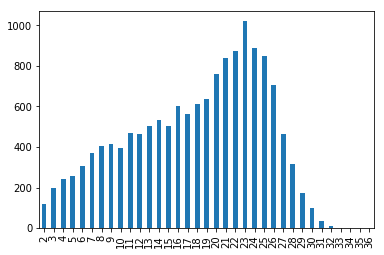



These tweets split up across the airlines as follows:
United : 3822
US Airways : 2913
American : 2759
Southwest : 2420
Delta : 2222
Virgin America : 504


The tweets come pre-labeled with sentiment categories.
These categories along with their counts are as follows:
negative : 9178
neutral : 3099
positive : 2363


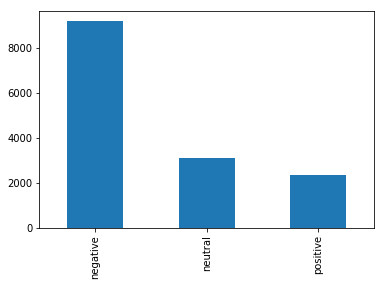

In [6]:
# Collecting statistics about the dataset
numTweets = len(tweets_df.index) # How many documents?
airlinesDistr = tweets_df["airline"].value_counts() # Distr. accross airlines
numAirlines = len(airlinesDistr.index) # How many airlines?
sentDistr = tweets_df["airline_sentiment"].value_counts() # Distr. accross sentiment categories
tweetLengths = tweets_df["text"].str.split(" ").apply(len)

# Compute descriptive statistics about the lengths of the tweets
minLength = tweetLengths.min() # Minimal number of words (note that e.g. "don't" is counted as 1 word) in a document
maxLength = tweetLengths.max() # Maximal number of words i a document
meanLength = tweetLengths.mean() # Mean number of words in a document

# Displaying the statistics in human-readable form
print("The dataset consists of " + str(numTweets) + \
      " tweets (documents) for a total of " + str(numAirlines) + " US airlines.")
print(f"The number of words in a tweet ranges between {minLength} and {maxLength} averaging at {int(meanLength + 1)}.")
print("Below is a plot of the distribution of the number of words in a tweet:")
tweetLengths.value_counts(sort = False).sort_index().plot.bar()
plt.show()
print("\n")
print("These tweets split up across the airlines as follows:")
for airline, count in airlinesDistr.iteritems():
  print(airline + " : " + str(count))
print("\n")
print("The tweets come pre-labeled with sentiment categories.\n\
These categories along with their counts are as follows:")
for sent, count in sentDistr.iteritems():
  print(sent + " : " + str(count))

# Plotting value counts of sentiment categories 
sentDistr.plot.bar();

***Observations and implications for model choice***: 
- We observe that the dataset comprizes a relatively small number of documents with an average length of 18 words, leading to a rogh estimate of total number of words in the dataset of 300K. The volume of the training set will be even smaller since parts of the dataset will be reserved for validation and testing purposes. ***Conclusion:*** In view of this observation,  we conclude that an effective transfer learning approach such as ULMFiT will be beneficial for the classification task at hand. 
- In view of the categories distribution, we are facing a classification problem with an imbalanced dataset with a ratio of approx. 9:3:2. Thus, the data set is biased toward the class of tweets with negative sentiment. ***Conclusion:***  The accuracy mertic might not be the right performance measure to evaluate the model as it will not be able to account for performance loss across the less frequent classes (positive and neutral). We note, however, that there does not seem to exist a standard measure of the degree of imbalance in the data, which could serve as an estimate of the extent to which negative effects of imbalanced data may be pronounced. 
- Depending on the application, improving the performance on one of the minority classes may be relatively more important. Here, we take an impartial standpoint and assume that performing well on any of the induced binary classification tasks is equally important. ***Conclusion:*** An overall evaluation metric, which summarizes suitable evaluation metrics for the binary classification taks in a balanced way will be considered as appropriate. More specifically, the **macro averaged F-beta score** (with beta = 1) will be used.
- The imbalance in the dataset also necessitates to use a loss function other that the standard choice of the cross entropy loss. Indeed, the loss function has to be alligned with the evaluation metric in order for the training procedure to produce a useful model. Here we propose to use a loss function which corresponds to a continuous version of the F-beta evaluation metric. Note that the F-beta metric cannot be used as a loss function itself since it is not differentiable. Out loss function, the so-called **continuous F-beta score loss (CFbetaScoreLoss)**, is based on computing the true positive (tp), false negative (fn) and false positive (fp) statistics for each of the three classes (more generally, n classes). The values of these statistics are then used to compute the F-beta score for each of the classes according to formula 
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/6fbeb471033fdd63a2c2ca7830afc7abdf8b8134 "F-beta formula"). The value of the loss function is computed by averaging the class-specific F-beta scores. Now, the tp-, fn- and fp-statistics are calculated as follows: When traversing the training/validation/tes set, for any sample-class pair, the prediction probability for the particular class is added to the  tp-statistic of that class. The sum of the prediction probabilities for the other two classes is added to the fn-statistic of that class while prediction probabilities for the other two classes are each added to their respective fp-statistics. The continuous F-beta score is more closely correlated with the F-beta score than the cross entropy loss in the sense that by going from a scenario with a lower CFbetaScoreLoss to one with a higher CFbetaScoreLoss, the corresponding F-Beta scores will preserve the ordering of the losses, which, however, is not guaranteed when ordering scenarios based on the cross entropy loss. Eventhough the cross entropy loss is widely used and typically does well in practice, we find the use of the CFbetaScoreLoss more appealing from a theoretic standpoint. An alternative loss function would be the weighted cross-entropy loss (weights equal to the inverse class priors). In our experiments, we have not observed any substantial difference in performance between models obtained by using either of the two loss functions. However, we decided to used the CFbetaScoreLoss does to its explicit relation to the F-beta score evaluation metric.  The CFbetaLoss is implemented in the eponymic class further down in the notebook.

**Data Cleaning** 

Below we perform some data cleaning, which involves removing  "words" of the form @string. This is done in order to get rid of references to the airline companies (e.g. @VirginAmerica) appearing in the tweets as these do not carry linguistic signals with respect to the sentiment in the tweets. Finally, we compute the number of words in the post-cleaning tweets data corpus.

In [7]:
# Extract the text and the sentiment categories
# Columns are swapped for later use with TextLMDataBunch.from_df
data_df = tweets_df[["airline_sentiment", "text"]].copy()

# Mapping negative to 0, positive to 1 and neutral to 2.
ctg_map = {"negative" : 0, "positive" : 1, "neutral" : 2}
data_df.replace({"airline_sentiment" : ctg_map}, inplace = True)

# Getting rid of @Airline and other text components of the form @substring
data_df["text"] = data_df["text"].str.replace(r'@[^\s]+', "")

# Keeping only alphabets
#data_df["text"] = data_df["text"].str.replace(r'[^a-zA-Z]', " ")

# Computing the total number of remaining words words 
number_words = len(word_tokenize(data_df["text"].str.cat(sep = " ")))
print(f"Number of words after some data cleaning: {number_words}")

# Save data_df to a csv file
data_df.to_csv(path/"data.csv", index=False, header=False)

data_df.columns = ["sentiment", "tweet"]

data_df.head()

Number of words after some data cleaning: 287880


,sentiment,tweet
0,2,What said.
1,1,plus you've added commercials to the experien...
2,2,I didn't today... Must mean I need to take an...
3,0,"it's really aggressive to blast obnoxious ""en..."
4,0,and it's a really big bad thing about it


**LANGUAGE MODEL FINE-TUNING**

**Preparing the data**

In [0]:
# Splitting available data into training and validation sets
# (Use of stratified sampling necessary due to class imbalance to unsure that relative class frequencies are preserved)
trn_set, val_set = train_test_split(data_df, 
                                    stratify = data_df['sentiment'], 
                                    test_size = 0.2, 
                                    random_state = 7)

# LM data
data_lm = TextLMDataBunch.from_df(path = "", 
                                  train_df = trn_set, 
                                  valid_df = val_set)
# Saving tha data
data_lm.save(path/'data_lm.pkl')

In [0]:
# Loading the data for a forward LM
data_lm_fw = load_data(path, 'data_lm.pkl')
# Loading the data for a backward LM
data_lm_bw = load_data(path, 'data_lm.pkl', backwards = True)

In [10]:
data_lm_fw.show_batch()

idx,text
0,hours 24 minutes on hold to be told i need to log in to xxup u.s. xxmaj airways website and there was nothing else to be done xxbos the drunk guy you xxunk out of flight xxup xxunk 4hrs ago is better off than the rest of us held up for 5hrs in the plane without food . xxbos please email me at xxunk willing to discuss my experience &
1,them ? when i called the rep said some other people booked our seats . xxbos i paid for my seat . i expect to be able to use my full seat xxbos not to mention the fact that we paid extra just to fly jetblue thinking it was the most reliable .. xxbos . received an error online and have been on hold for over 1.5 hours . xxmaj
2,? xxbos xxmaj none of the # xxup lax flights into # xxup dfw have been xxmaj cancelled xxmaj flightled . xxmaj those landing before and after ours are fine . xxmaj completely arbitrary . xxbos oh yay ! xxmaj now gate agents decide not to deal with upgrade list and just bump up whoever is closest . xxbos i believe . xxmaj it was xxmaj cancelled xxmaj flighted yesterday
3,a call through due to high volume -- can u help ? xxbos xxmaj now ur asking for the heavy xxunk ! xxmaj you know # xxunk https : / / t.co / xxunk # brandmance # lovesongfriday xxbos 45 minute wait for my bags . xxmaj just what i needed on a xxmaj sunday night . xxbos anyone there to help ? xxmaj still on hold ... xxbos me
4,cle offered one . xxmaj not usual gr8 southwest customer service i love xxbos it eventually arrived . just seemed really slow . :) xxbos no warm weather hubs means no xxmaj mexico for us . xxmaj and i ca n't go anywhere else since you lost my bags . i hope you attempt to rectify xxbos : xxmaj when xxmaj you 've xxmaj got to xxmaj get xxmaj there


**Fine-tuning the forward language model**

In [0]:
# Creating learner object using data_lm and pretrained AWD-LSTM model
learn = language_model_learner(data_lm_fw, AWD_LSTM, 
                               drop_mult = 0.9)

In [12]:
learn.layer_groups, len(learn.layer_groups)

([Sequential(
    (0): WeightDropout(
      (module): LSTM(400, 1152, batch_first=True)
    )
    (1): RNNDropout()
  ), Sequential(
    (0): WeightDropout(
      (module): LSTM(1152, 1152, batch_first=True)
    )
    (1): RNNDropout()
  ), Sequential(
    (0): WeightDropout(
      (module): LSTM(1152, 400, batch_first=True)
    )
    (1): RNNDropout()
  ), Sequential(
    (0): Embedding(5656, 400, padding_idx=1)
    (1): EmbeddingDropout(
      (emb): Embedding(5656, 400, padding_idx=1)
    )
    (2): LinearDecoder(
      (decoder): Linear(in_features=400, out_features=5656, bias=True)
      (output_dp): RNNDropout()
    )
  )], 4)

Hence,  the model is split up into 4 layer groups. This will be taken into account when performing discriminative fine-tuning.

First we need to select a learning rate.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


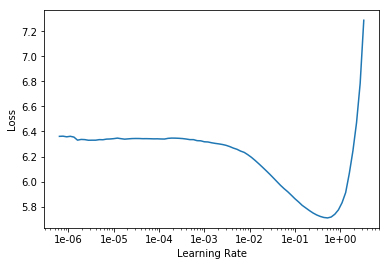

In [13]:
# Use the learning rate finder to find a suitable learning rate
learn.lr_find()
learn.recorder.plot()

Here 5e-2 looks like a good value, a tenth of the minimum of the curve. That's going to be the highest learning rate in 1cycle-policy training.

Initially, we train the model in frozen state, which means that only last layer goup consisting of the embedding layer  and the head of the langiage model (see above list of layer groups) is trainable. The training is done for one epoch only and serves the purpose of tuning the embeddings to the vocabulary of the tweets dataset.  

In [14]:
# Running the learner to fine-tune the embeddings and the head of the LM 
learn.fit_one_cycle(cyc_len = 1, max_lr = 1e-2, wd = 0.9)

epoch,train_loss,valid_loss,accuracy,time
0,4.906938,4.251448,0.237974,00:10


Now, we unfreeze the model and fine-tune it on the corpus of the tweet dataset. The number of epochs was determined experimentally and chosen at the point where the validation loss started increasing after the initial phase of decreasing behaviour. The obtained number of epochs seems plausible given the small size of the training set.

In [0]:
# Unfreezing the model for complete fine-tuning it
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,4.278796,3.949189,0.272949,00:13
1,4.090685,3.875297,0.281417,00:14
2,3.929527,3.831213,0.286872,00:14
3,3.738477,3.775840,0.291867,00:14
4,3.576485,3.754253,0.295675,00:13


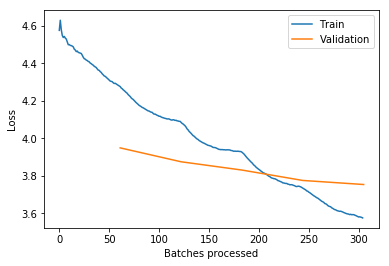

In [16]:
# Here we are using discriminative learning rates as described in the ULMFiT paper
learn.fit_one_cycle(cyc_len = 5, max_lr = learn.lr_range(slice(1e-2/(2.6**4), 1e-2)), wd = 0.9)
learn.recorder.plot_losses()

In [0]:

#Exporting the state of the forward LM learner
#learn.export("trained_lm_fw.pkl")

# Downloading the learner
#files.download(path/'trained_lm_fw.pkl') 

# Uploading the file containing learner data
#uploaded = files.upload()

#for fn in uploaded.keys():
#  print('Uploaded file "{name}" with length {length} bytes'.format(
#      name=fn, length=len(uploaded[fn])))
#!mv trained_lm_fw.pkl SentAnalysisData

# Loading the learner
#learn = load_learner(path, 'trained_lm_fw.pkl')

In [0]:
# Saving the fine-tuned forward LM
learn.save_encoder('lm_fw')

**Fine-tuning the backward language model**

In [0]:
# Creating learner object using data_lm and pretrained AWD-LSTM model
learn = language_model_learner(data_lm_bw, AWD_LSTM, 
                               drop_mult = 0.9)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


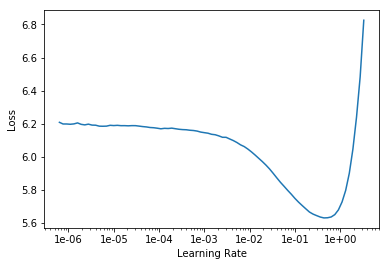

In [20]:
# Use the learning rate finder to find a suitable learning rate
learn.lr_find()
learn.recorder.plot()

In [21]:
# Running the learner to fine-tune the embeddings
learn.fit_one_cycle(cyc_len = 1, max_lr=1e-2, wd = 0.9)

epoch,train_loss,valid_loss,accuracy,time
0,4.897557,4.268865,0.256278,00:10


In [0]:
# Unfreezing the model and fine-tuning it
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,4.287519,3.949054,0.291867,00:14
1,4.088089,3.870105,0.300893,00:14
2,3.917218,3.811785,0.307896,00:13
3,3.732349,3.772600,0.314090,00:13
4,3.563064,3.758335,0.316225,00:13


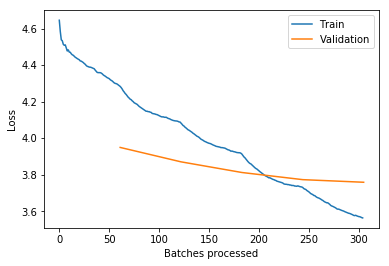

In [23]:
# Here we are using discriminative learning rates as described in the ULMFiT paper
learn.fit_one_cycle(cyc_len = 5, max_lr = learn.lr_range(slice(1e-2/(2.6**4), 1e-2)), wd = 0.9)
learn.recorder.plot_losses()

In [0]:
#Exporting the state of the forward LM learner
#learn.export("trained_lm_bw.pkl")

# Downloading the learner
#files.download(path/'trained_lm_bw.pkl') 

# Uploading the file containing learner data
#uploaded = files.upload()

#for fn in uploaded.keys():
#  print('Uploaded file "{name}" with length {length} bytes'.format(
#      name=fn, length=len(uploaded[fn])))
#!mv trained_lm_bw.pkl SentAnalysisData

# Loading the learner
#learn = load_learner(path, 'trained_lm_bw.pkl')

In [0]:
# Saving the fine-tuned backward language model
learn.save_encoder('lm_bw')

**Discussion:** We observe that despite fine-tuning the  hyperparameters, the difference between the training loss and the validation loss is relatively large, which is possibly due to the substantial class imbalance. Certainly, the statistical distribution of words in a peacce of text is highly dependent on the sentiment encoded in the text. The stronger this dependence and the more servere the class imbalance is, the larger the discrepancy between the training and the validation loss will be. Some further fine tuning of the model's hyperparameters might be necessary here in order to achieve better performance of the fine/tuned language model.

**TRAINING THE CLASSIFIER**

**Preparing the data**

In [0]:
# Splitting available data into training, validation and test sets (60/20/20)
# (Use of stratified sampling necessary due to class imbalance
# to unsure that relative class frequencies are preserved)
trn_set0, test_set = train_test_split(data_df, 
                                      stratify = data_df['sentiment'], 
                                      test_size = 0.2, 
                                      random_state = 12) 

trn_set, val_set = train_test_split(trn_set0, 
                                    stratify = trn_set0['sentiment'], 
                                    test_size = 0.25, 
                                    random_state = 12)


# Classifier data
data_clas = TextClasDataBunch.from_df(path = "", 
                                      train_df = trn_set, 
                                      valid_df = val_set,
                                      test_df = test_set,
                                      vocab = data_lm.vocab)
# Auxiliary text data bunch
data_clas_aux = TextClasDataBunch.from_df(path = "", 
                                          train_df = trn_set, 
                                          valid_df = test_set,
                                          vocab = data_lm.vocab)

# Savinf the data
data_clas.save(path/'data_clas.pkl')
data_clas_aux.save(path/'data_clas_aux.pkl')

As suggested in the ULMFiT paper, we train a forward and a backward classifier using the forward and backward language models obtained by fine-tuning a pretrained model above.

In [0]:
# Loading the data for a forward LM
data_clas_fw = load_data(path, 'data_clas.pkl', bs = 128)
# Loading the data for a backward LM
data_clas_bw = load_data(path, 'data_clas.pkl', backwards = True)
# Loading the data for a backward LM
data_clas_bw_aux = load_data(path, 'data_clas_aux.pkl', backwards = True)

In [28]:
data_clas_fw.show_batch()

text,target
xxbos i xxup just xxup asked xxup my xxup boyfriend xxup to xxup xxunk xxup over xxup the xxup xxunk xxup on xxup flight xxunk xxup he xxup said xxup yes xxrep 4 ! xxup best xxup day xxup ever ! ! ! xxup thank u xxup so xxup much xxrep 6 !,1
xxbos xxup where xxup is xxup my xxup fucking xxup bag ? ! ? ! xxmaj where the fuck is my fucking bag ? ? ? xxup tell xxup me xxup now xxup or xxup give xxup me a xxup number xxup to xxup call a xxup human . xxup xxunk m,0
xxbos xxmaj the xxmaj fact xxmaj that u xxmaj see xxmaj black xxmaj history xxmaj month 12 xxmaj months a xxmaj year xxmaj is xxmaj xxunk ! xxmaj we xxup will xxup be xxmaj an xxmaj xxunk xxmaj base xxmaj for xxmaj corp. xxmaj like u xxmaj in xxmaj future !,1
xxbos xxmaj hi . i have xxup koa - xxup lax - xxup phl - xxup ord booked as a 1-way xxunk xxunk . xxmaj if i called to chnge it to xxup koa - xxup lax - xxup phx - xxup ord would i have to pay any fees,2
"xxbos e xxrep 4 y ! xxmaj cancelled xxmaj flightlations , xxmaj flight xxmaj booking xxmaj problemss , reflight xxmaj booking xxmaj problemss , but y' all got me on the same flight out tonight ( not tomorrow ) & & the xxup fc upgrade . xxmaj thx !",1


**Fine-tuning the classifiers**


First we create a custom evaluation metric for the problem at hand. More specifically, below, we implement the F-beta score, which is computed on the validation set at the end of each training epoch. The implementation utilizes the callback system of the fastai library. Note that at the time of writing the fastai library lacks a suitable implementation of the F-beta score computed on the validation set.

In [0]:
@dataclass
class ConfusionMatrixOnVal(Callback):
    "Computes the confusion matrix on the validation set."
    learn:Learner
    
    def on_train_begin(self, **kwargs):
        self.n_classes = 0
    
    def on_epoch_begin(self, **kwargs):
        self.cm = None
    
    def on_epoch_end(self, **kwargs):
        val_dl = self.learn.dl()
        # Looping necessary since intermediate matrices might not fit into memory
        for batch in val_dl:
          _, targs = batch
          preds = self.learn.pred_batch(batch = batch)
          if self.n_classes == 0:
            self.n_classes = preds.shape[-1]
            self.x = torch.arange(0, self.n_classes)
          preds = preds.argmax(-1).view(-1).cpu()
          targs = targs.cpu()
          cm = ((preds == self.x[:, None]) & (targs == self.x[:, None, None])).sum(dim = 2, dtype=torch.float32)
          if self.cm is None: self.cm =  cm
          else: self.cm += cm
            
# The implementation of this class is equal to the one of the CMScore class of the fastai library.        
@dataclass
class CMScoresOnVal(ConfusionMatrixOnVal):
    "Base class for metrics which rely on the calculation of the precision and/or recall scores computed on the validation set."
    average:Optional[str]="binary"      # `binary`, `micro`, `macro`, `weigthed` or None
    pos_label:int=1                     # 0 or 1
    eps:float=1e-9

    def _recall(self):
        rec = torch.diag(self.cm) / self.cm.sum(dim = 1)
        if self.average is None: return rec
        else:
            if self.average == "micro": weights = self._weights(avg = "weighted")
            else: weights = self._weights(avg = self.average)
            return (rec * weights).sum()

    def _precision(self):
        prec = torch.diag(self.cm) / self.cm.sum(dim = 0)
        if self.average is None: return prec
        else:
            weights = self._weights(avg = self.average)
            print((prec * weights).sum())
            return (prec * weights).sum()

    def _weights(self, avg:str):
        if self.n_classes != 2 and avg == "binary":
            avg = self.average = "macro"
            warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")
        if avg == "binary":
            if self.pos_label not in (0, 1):
                self.pos_label = 1
                warn("Invalid value for pos_label. It has now been set to 1.")
            if self.pos_label == 1: return Tensor([0,1])
            else: return Tensor([1,0])
        elif avg == "micro": return self.cm.sum(dim=0) / self.cm.sum()
        elif avg == "macro": return torch.ones((self.n_classes,)) / self.n_classes
        elif avg == "weighted": return self.cm.sum(dim=1) / self.cm.sum()

@dataclass
class FBetaOnVal(CMScoresOnVal):
    "Computes the F`beta` score on the validation set."
    beta:float=1
    #name:str="f_" + str(beta) + " score"
    name:str="f_score"
      
    def on_train_begin(self, **kwargs):
        super().on_train_begin(**kwargs)
        self.beta2 = self.beta ** 2
        self.avg = self.average
        if self.average != "micro": self.average = None 

    def on_epoch_end(self, last_metrics, **kwargs):
        super().on_epoch_end(**kwargs)
        prec = self._precision()
        rec = self._recall()
        metric = (1 + self.beta2) * prec * rec / (prec * self.beta2 + rec + self.eps)
        metric[metric != metric] = 0  # removing potential "nan"s
        if self.avg: metric = (self._weights(avg = self.avg) * metric).sum()
        return add_metrics(last_metrics, metric)

    def on_train_end(self, **kwargs): self.average = self.avg

Next, we implement the continuous version of the macro-averaged F-beta score.

In [0]:
#Implementation of the continuous F-beta score loss
class CFScoreLoss(nn.Module):

    def __init__(self, beta, n_classes, eps = 1e-9):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.beta = beta
        self.n_classes = n_classes
        self.eps = eps
        self.tp = torch.zeros((n_classes,), device = self.device)
        self.fn = torch.zeros((n_classes,), device = self.device)
        self.fp = torch.zeros((n_classes,), device = self.device)
        self.encoder = torch.eye(n_classes, device = self.device)
        self.sm = torch.nn.Softmax(1)

    def forward(self, preds, targs):  
        preds = self.sm(preds)
        targs = self.encoder[targs]
        self.tp = torch.sum(targs*preds, dim = 0)
        self.fn = torch.sum(targs*torch.sum((1 - targs)*preds, dim = 1)[:, None], dim = 0)
        self.fp = torch.sum((1 - targs)*preds, dim = 0)

        fscores = (1 + self.beta**2)*self.tp/((1 + self.beta**2)*self.tp + self.beta**2*self.fn + self.fp + self.eps)
        fscore = torch.sum(fscores)/self.n_classes
        return 1 - fscore

In [0]:
# Instantiating the continuous F-beta score loss
loss = CFScoreLoss(1, 3)

***Forward classifier***

Initially, we train the model in frozen state, which means that only the decoding (or classifying layer) is trained. 

In [0]:
# Creating learner object using data_lm and AWD-LSTM model
learn_fw = text_classifier_learner(data_clas_fw, AWD_LSTM,
                                   loss_func = loss,
                                   drop_mult = 0.5, 
                                   pretrained = False)


# Initializing the classifier model with the weights of the fine-tuned language model
learn_fw.load_encoder('lm_fw')

# Setting up the metrics
fbeta = FBetaOnVal(learn_fw, average = "macro")
learn_fw.metrics = [accuracy, fbeta]

In [0]:
learn_fw.data.test_ds.y = data_clas_aux.valid_ds.y
learn_fw.data.test_dl = data_clas_aux.valid_dl

In [34]:
(learn_fw.layer_groups, len(learn_fw.layer_groups))

([Sequential(
    (0): Embedding(5656, 400, padding_idx=1)
    (1): EmbeddingDropout(
      (emb): Embedding(5656, 400, padding_idx=1)
    )
  ), Sequential(
    (0): WeightDropout(
      (module): LSTM(400, 1152, batch_first=True)
    )
    (1): RNNDropout()
  ), Sequential(
    (0): WeightDropout(
      (module): LSTM(1152, 1152, batch_first=True)
    )
    (1): RNNDropout()
  ), Sequential(
    (0): WeightDropout(
      (module): LSTM(1152, 400, batch_first=True)
    )
    (1): RNNDropout()
  ), Sequential(
    (0): PoolingLinearClassifier(
      (layers): Sequential(
        (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Dropout(p=0.2)
        (2): Linear(in_features=1200, out_features=50, bias=True)
        (3): ReLU(inplace)
        (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): Dropout(p=0.1)
        (6): Linear(in_features=50, out_features=3, bias=True)
      )
    )
  )], 5)

Hence, the model is split up into 5 layer groups. This will be taken into account when performing discriminative fine-tuning.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-01
Min loss divided by 10: 1.32E-01


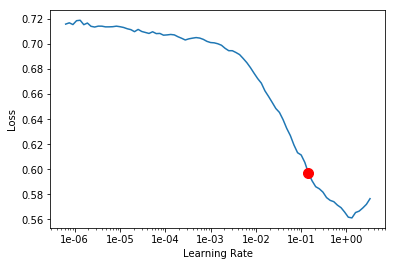

In [35]:
learn_fw.lr_find()
learn_fw.recorder.plot(suggestion = True)

We found any value  around 1e-2 for the learning rate to lead to the best performance.

In [0]:
#Pick a learning rate to start the fine-tuning process with
lr = 1e-2

In [37]:
# Fine-tune the head of the model
learn_fw.fit_one_cycle(cyc_len = 1, max_lr = lr, moms=(0.8,0.7), wd = 0.1)

epoch,train_loss,valid_loss,accuracy,f_score,time
0,0.479462,0.346544,0.762978,0.690758,00:06


Now, gradually unfreeze the model.

In [38]:
learn_fw.freeze_to(-2)
learn_fw.fit_one_cycle(cyc_len = 1, max_lr = learn_fw.lr_range(slice(lr/2/(2.6**5), lr/2)), moms=(0.8,0.7), wd = 0.1)

epoch,train_loss,valid_loss,accuracy,f_score,time
0,0.409951,0.338097,0.760246,0.688430,00:06


In [39]:
learn_fw.freeze_to(-3)
learn_fw.fit_one_cycle(cyc_len = 1, max_lr = learn_fw.lr_range(slice(lr/4/(2.6**5), lr/4)), moms=(0.8,0.7), wd = 0.1)

epoch,train_loss,valid_loss,accuracy,f_score,time
0,0.371562,0.351991,0.761270,0.664998,00:09


The number of epochs in the final fine-tuning step was tuned on the validation set.

In [40]:
learn_fw.unfreeze()
learn_fw.fit_one_cycle(cyc_len = 7, max_lr = learn_fw.lr_range(slice(lr/10/(2.6**5), lr/10)), moms=(0.8,0.7), wd = 0.1)

epoch,train_loss,valid_loss,accuracy,f_score,time
0,0.326711,0.309040,0.778347,0.716340,00:11
1,0.346340,0.301169,0.788593,0.727629,00:12
2,0.317414,0.294995,0.791667,0.735637,00:11
3,0.323889,0.294773,0.798839,0.736330,00:11
4,0.299588,0.290460,0.797473,0.740698,00:11
5,0.286589,0.285901,0.804303,0.749271,00:11
6,0.290573,0.283786,0.797473,0.744911,00:11


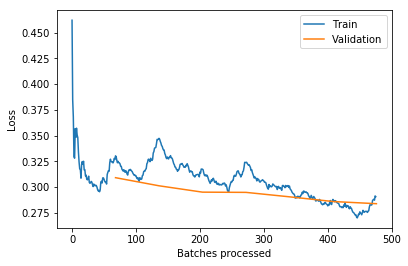

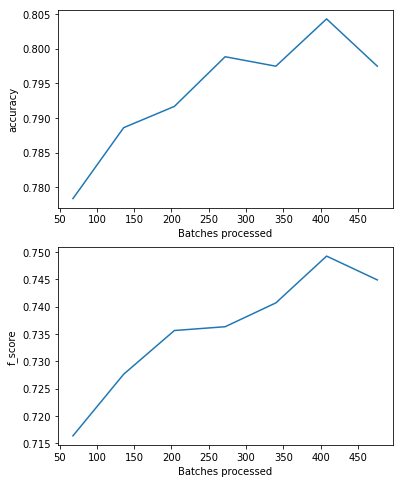

In [41]:

learn_fw.recorder.plot_losses()
learn_fw.recorder.plot_metrics()

In [0]:
learn_fw.save('clas_fw')

***Backward classifier***

In [0]:
# Creating learner object using data_lm and AWD-LSTM model
learn_bw = text_classifier_learner(data_clas_bw, AWD_LSTM,
                                   loss_func = loss,
                                   drop_mult = 0.5, 
                                   pretrained = False)

# Initializing the classifier model with the weights of the fine-tuned language model
learn_bw.load_encoder('lm_bw')

fbeta = FBetaOnVal(learn_bw, average = "macro")
learn_bw.metrics = [accuracy, fbeta]

In [0]:
learn_bw.data.test_ds.y = data_clas_bw_aux.valid_ds.y
learn_bw.data.test_dl = data_clas_bw_aux.valid_dl

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-02
Min loss divided by 10: 5.25E-02


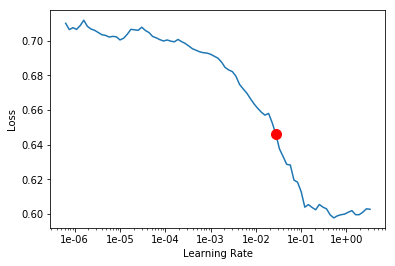

In [45]:
learn_bw.lr_find()
learn_bw.recorder.plot(suggestion = True)

Experiments have shown that best performance is obtained by setting the learning rate = 1e-2.

In [0]:
lr = 1e-2

In [47]:
# Fine-tune the head of the model
learn_bw.fit_one_cycle(cyc_len = 1, max_lr = lr, wd = 0.3)

epoch,train_loss,valid_loss,accuracy,f_score,time
0,0.464825,0.366624,0.741120,0.673790,00:06


In [48]:
learn_bw.freeze_to(-2)
learn_bw.fit_one_cycle(1, slice(lr/2/(2.6**5), lr/2), moms=(0.8,0.7), wd = 0.1)

epoch,train_loss,valid_loss,accuracy,f_score,time
0,0.427006,0.334100,0.765710,0.700319,00:07


In [49]:
learn_bw.freeze_to(-3)
learn_bw.fit_one_cycle(1, slice(lr/4/(2.6**5), lr/4), moms=(0.8,0.7), wd = 0.1)

epoch,train_loss,valid_loss,accuracy,f_score,time
0,0.351571,0.329398,0.776298,0.700235,00:10


In [50]:
learn_bw.unfreeze()
learn_bw.fit_one_cycle(7, slice(lr/10/(2.6**5), lr/10), moms=(0.8,0.7), wd = 0.1)

epoch,train_loss,valid_loss,accuracy,f_score,time
0,0.342962,0.318713,0.775956,0.701390,00:13
1,0.320660,0.314373,0.786202,0.724063,00:12
2,0.329105,0.300320,0.790301,0.725375,00:13
3,0.300725,0.299476,0.795082,0.734774,00:14
4,0.296823,0.296012,0.804645,0.738278,00:13
5,0.268361,0.288533,0.799522,0.736371,00:13
6,0.265939,0.287680,0.801230,0.740114,00:13


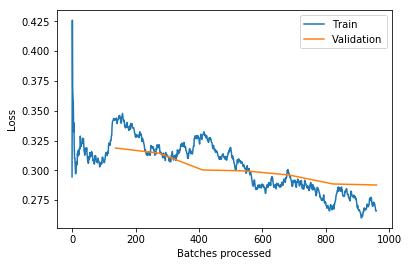

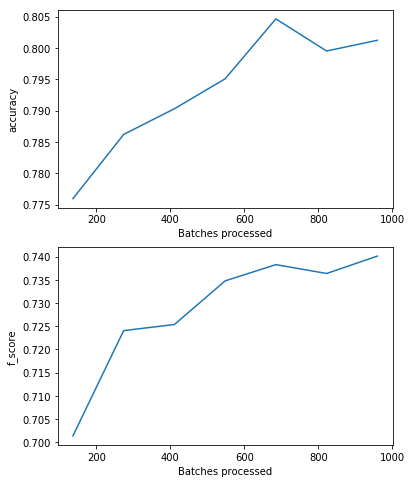

In [51]:
learn_bw.recorder.plot_losses()
learn_bw.recorder.plot_metrics()

In [0]:
learn_bw.save('clas_bw')

**Create the classifier**

Here we apply out forward and backward classifiers to predict sentiment on the test data:

In [0]:
predictions_fw, labels_fw = learn_fw.get_preds(ds_type = DatasetType.Test, ordered = True)

In [0]:
predictions_bw, labels_bw = learn_bw.get_preds(ds_type = DatasetType.Test, ordered = True)

Finally, the predictions are combined:

In [0]:
predictions = (predictions_fw + predictions_bw)/2

In [56]:
len(predictions)

2928

In [57]:
accuracy(predictions, labels_fw)

tensor(0.8190)

Here we compute the precision, recall and f1 scores for each of the classes separately. We observe the typical relatively law performance of the classifier on the infrequent classes (positive, neutral).

In [58]:
# Printing the classification report
print(sklmetrics.classification_report(labels_fw.numpy(),
                            predictions.argmax(-1).numpy(),
                            target_names = ["negative", "positive", "neutral"]))

              precision    recall  f1-score   support

    negative       0.87      0.90      0.89      1836
    positive       0.75      0.72      0.73       472
     neutral       0.70      0.65      0.67       620

    accuracy                           0.82      2928
   macro avg       0.77      0.76      0.76      2928
weighted avg       0.82      0.82      0.82      2928



In [59]:
# Computing the confision matrix
print(sklmetrics.confusion_matrix(labels_fw.numpy(),
                            predictions.argmax(-1).numpy()))

[[1656   57  123]
 [  82  338   52]
 [ 161   55  404]]


Computing the F-beta score (beta = 1) of the predictions on the test set:

In [60]:
sklmetrics.fbeta_score(labels_fw.numpy(), predictions.argmax(-1).numpy(), 
                       average = 'macro', 
                       beta = 1) 

0.7646102068507886

Computing the average log-probabilities of the predicted class probabilities for each class:

In [61]:
[torch.mean(torch.max(torch.nn.LogSoftmax(dim = 1)(predictions), dim = 1).values[labels_fw == clas]) for clas in range(3)]

[tensor(-0.0287), tensor(-0.0521), tensor(-0.0630)]

**Discussion:** We obtain a macro-averaged  F1 score of 0.76 and an accuracy rate of 82%. From the classification report we see that the model performs by far best on the majority class ("negative") achieving there a precision rate of 87% and a recall rate of 90%. This was to be expected, although we tried to strike a balanced performance by using a loss function which is syncronized with the macro averaged F-1 score. The confusion matrix also reveals that on the minority classes the prediction errors are to a greater extent due to the bias towards the majority class. Interestingly enough, the model performs significantly better on the class of "positive" sentiment than on the class of "neutral" sentiment even though these two classes are almost equally represented in the data (the class of neutral sentiment is even "bigger"). This might be due to the fact that the class of neutral sentiment is more difficult to detect, which is suggested by the fact that the average log-likelihood of class probabilities is minimal (-0.0638) for the class of "neutral" sentiment. Note that in the present context, the log-likelihood of a class' probability can be considered a measure of how confident the classifier is about its output. Finally, we would like to point out tha the achieved classification performance is significantly below the performance of the best performing classifier in [Sentiment Classification System of Twitter Data for US Airline Service Analysis](https://ieeexplore.ieee.org/document/8377739), though we note that our results are not directly comparable with those in the cited paper as the used training and test sets do not coincide. However, given that the difference in the performance is significant, it is plausible to assume that our classifier performs worse. A possible explanation for this may be the fact that there is certainly a significant discrepancy in the distribution of words in the text corpus used for the pretraining of the language model and the distribution of words in the corpus of tweets used for fine-tuning the pre-trained language model. Given that the size of the pre-training text corpus is bigger than the size of the tweets text corpus by at least 2 orders of magnitude, it is reasonable to assume that the amount of data available for fine-tuning the language model is not sufficient. A possibile solution to this problems would be to augment the US Airline Twitter data by some other Twitter data and fine-tune the language model using this enlarged dataset. This would allow the language model to better adapt to the idiosyncracies of the Twitter language which in turn would allow the classifier to better extract the linguistic signalsrelevant  with respect to the sentiment in the Twitter data.